# GIS and Machine Learning with Python

This workshop is designed to get you familiar with basic GIS and machine learning functionality with a python SW stack. 

By the end of these lessions, you should be able to:
 - Download, explore, and plot from spatial files
 - Do basic manipulations of spatial shapes
 - Perform basic spatial analyses
 - Combine results from a machine learning model with spatial data

This workshop will be done using Jupyter Notebooks and requires the following modules:
     - GIS Modules
            - Geopandas
            - Shapely
            - Pyproj
            - Fiona
            - Geopy
            - Proximity Hash
            - Geohash
            
     - General Purpose Modules
             - Pandas
             - Matplotlib
             - Numpy
             - Pylab
             - Time
             - Sys

In [3]:
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon
import shapely.geometry
import pyproj
from fiona.crs import from_string, to_string
from geopy.geocoders import Nominatim
import proximityhash
# import _geohash

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sys

# set optional visual parameters for pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt.rcParams['image.cmap'] = 'YlGn'


# set optional display parameters for pandas
pd.options.display.max_rows = 6

# Activate Geopy geocoder
geolocator = Nominatim()

## Part 1 - Basic GIS

1.1 Geometry

Geography is underlaid by geometrical shapes. When working with the geo-tools, we'll be dealing with 3 main elements: points, lines, and polygons. In this first section, we'll practice creating, analyzing and manipulating these elements.

2D Points

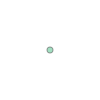

In [23]:

point1 = Point(1.2, 50) 
point2 = Point(5, -42.0)
point3 = Point(-6, 3.5)
point1

In [38]:
print(point1)

POINT (1.2 50)


In [20]:
# 2D Points have a few use methods and attributes including: coordinates, geom_type, distance
point1.x, point1.y, point1.coords.xy

(1.2, 50.0, (array('d', [1.2]), array('d', [50.0])))

In [19]:
# If you ever get confused about what a shapely object is, you can call "geom_type"
point1.geom_type

'Point'

In [22]:
# Given another point, the "distance" method an calclate the distance
point1.distance(point2)

92.078444817449

 LineStrings

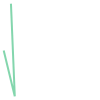

In [24]:

# We can create lines by entering coordinates, or by using points

line1 = LineString([point1, point2, point3])
line1



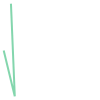

In [27]:
# I can enter the coordinate of our original points and get the same result

line2 = LineString([(1.2, 50), (5, -42.0), (-6, 3.5)])
line2

In [28]:
print(line1)

LINESTRING (1.2 50, 5 -42, -6 3.5)


In [29]:
line1.geom_type

'LineString'

In [31]:
# the 'centroid' method
print(line1.centroid)

POINT (1.886667356320875 -3.836106657094351)


In [33]:
# the "boundary" method
print(line1.boundary)

MULTIPOINT (1.2 50, -6 3.5)


In [35]:
# the 'length' attribute
line1.length

138.88923417204117

In [37]:
# We can also get the x & y coordinates of the line
line1.xy

(array('d', [1.2, 5.0, -6.0]), array('d', [50.0, -42.0, 3.5]))

Polygons

We can create polygons from points (by using their coordinates), or by inputing coordinates.

Using the previously generated points....

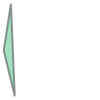

In [40]:
# Create polygon from coordinates

poly1 = Polygon([(1.2, 50), (5, -42.0), (-6, 3.5)])
poly1

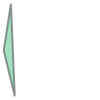

In [44]:
# Using something similar to a list comprehension, we can also generate the polygon using the coordinates of points

poly2 = Polygon([[point.x, point.y] for point in [point1, point2, point3]])
poly2